# LA Restaurant Health Inspection

https://data.lacounty.gov/Health/LOS-ANGELES-COUNTY-RESTAURANT-AND-MARKET-INSPECTIO/6ni6-h5kp
https://data.lacounty.gov/Health/LOS-ANGELES-COUNTY-RESTAURANT-AND-MARKET-VIOLATION/8jyd-4pv9

Datasets with geographical data such as latitudes, longitudes, and FIPS codes lend themselves really well to visualization through mapping packages. While state codes and FIPS county codes are widely used in mapping packages, I wanted to map out ZIP code level data while working with GeoJSON.

We look at the LA county restaurant and market inspection dataset for this purpose. There are two separate csv files available: one for inspection records and one for violation records. What's the process like from a high level?
1. Clean up data types
2. Create new features
3. Transform the violation records and merge with inspection records
4. Find appropriate GeoJSON
5. Visualize some data

In [525]:
import pandas as pd
import re
from datetime import datetime
from dateutil.parser import parse
import missingno as msno
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import json

In [526]:
inspect_df = pd.read_csv('restaurant-and-market-health-inspections.csv')

In [527]:
violate_df = pd.read_csv('restaurant-and-market-health-violations.csv')

In [528]:
inspect_df.dtypes

serial_number          object
activity_date          object
facility_name          object
score                   int64
grade                  object
service_code            int64
service_description    object
employee_id            object
facility_address       object
facility_city          object
facility_id            object
facility_state         object
facility_zip           object
owner_id               object
owner_name             object
pe_description         object
program_element_pe      int64
program_name           object
program_status         object
record_id              object
dtype: object

In [529]:
def dateobj(str):
    return datetime.strptime(str, '%Y-%m-%dT%H:%M:%S')

In [530]:
inspect_df['activity_date'] = inspect_df['activity_date'].apply(dateobj)
violate_df['activity_date'] = violate_df['activity_date'].apply(dateobj)

In [531]:
inspect_df.head()

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,facility_id,facility_state,facility_zip,owner_id,owner_name,pe_description,program_element_pe,program_name,program_status,record_id
0,DAJ00E07B,2017-12-29,HABITAT COFFEE SHOP,95,A,1,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,FA0170465,CA,90065,OW0178123,GLASSELL COFFEE SHOP LLC,RESTAURANT (0-30) SEATS MODERATE RISK,1631,HABITAT COFFEE SHOP,ACTIVE,PR0160774
1,DAQOKRFZB,2017-12-29,REILLY'S,92,A,1,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,FA0244690,CA,90045,OW0208441,"AREAS SKYVIEW LAX JV, LLC",RESTAURANT (0-30) SEATS MODERATE RISK,1631,REILLY'S,ACTIVE,PR0193026
2,DASJI4LUR,2017-12-29,STREET CHURROS,93,A,1,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,FA0224109,CA,90028,OW0228670,"STREETCHURROS, INC",RESTAURANT (0-30) SEATS LOW RISK,1630,STREET CHURROS,ACTIVE,PR0179282
3,DAWVA0CY3,2017-12-29,RIO GENTLEMANS CLUB,93,A,1,ROUTINE INSPECTION,EE0000958,13124 S FIGUEROA ST,LOS ANGELES,FA0046462,CA,90064,OW0011830,FIGUEROA GROUP INC,RESTAURANT (61-150) SEATS LOW RISK,1636,RIO GENTLEMANS CLUB,ACTIVE,PR0044776
4,DAKFCHD0L,2017-12-29,LE PAIN QUOTIDIEN,93,A,1,ROUTINE INSPECTION,EE0000629,13050 SAN VICENTE BLVD STE 114,LOS ANGELES,FA0034788,CA,90049,OW0028928,PQ SAN VICENTE INC.,RESTAURANT (61-150) SEATS HIGH RISK,1638,LE PAIN QUOTIDIEN,ACTIVE,PR0017456


In [532]:
inspect_df.shape

(58872, 20)

In [533]:
violate_df.head()

,serial_number,activity_date,facility_name,violation_code,violation_description,violation_status,points,grade,facility_address,facility_city,...,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,score,service_code,service_description,row_id
0,DA08R0TCU,2018-03-30,KRUANG TEDD,F030,# 30. Food properly stored; food storage conta...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF030
1,DA08R0TCU,2018-03-30,KRUANG TEDD,F027,# 27. Food separated and protected,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF027
2,DA08R0TCU,2018-03-30,KRUANG TEDD,F035,# 35. Equipment/Utensils - approved; installed...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF035
3,DA08R0TCU,2018-03-30,KRUANG TEDD,F033,# 33. Nonfood-contact surfaces clean and in go...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF033
4,DA08R0TCU,2018-03-30,KRUANG TEDD,F029,"# 29. Toxic substances properly identified, st...",OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF029


In [534]:
violate_df.dtypes

serial_number                    object
activity_date            datetime64[ns]
facility_name                    object
violation_code                   object
violation_description            object
violation_status                 object
points                            int64
grade                            object
facility_address                 object
facility_city                    object
facility_id                      object
facility_state                   object
facility_zip                     object
employee_id                      object
owner_id                         object
owner_name                       object
pe_description                   object
program_element_pe                int64
program_name                     object
program_status                   object
record_id                        object
score                             int64
service_code                      int64
service_description              object
row_id                           object


In [535]:
violate_df.shape

(272801, 25)

In [536]:
inspect_places = inspect_df['facility_name'].unique()

In [537]:
violate_places = violate_df['facility_name'].unique()

In [538]:
inspect_df['activity_date'].min()

Timestamp('2015-07-01 00:00:00')

In [539]:
inspect_df['activity_date'].max()

Timestamp('2018-03-30 00:00:00')

In [540]:
violate_df['activity_date'].min()

Timestamp('2015-10-01 00:00:00')

In [541]:
violate_df['activity_date'].max()

Timestamp('2018-03-30 00:00:00')

In [542]:
len(set(inspect_places) - set(violate_places))

301

In [543]:
len(inspect_places) - len(violate_places)


299

In [544]:
violate_df['violation_status'].value_counts()

OUT OF COMPLIANCE       272799
VIOLATION                    1
HOUSING NON-CRITICAL         1
Name: violation_status, dtype: int64

## Violation outliers

A look at the violation codes yield codes that mostly begin with a 'F'. There seem to be a few starting with 'W' that only appear once or twice. When matched with the violation description, they were the only descriptions that did not have a violation number in front of them. Furthermore, some didn't even result in point deductions. As they only make up 17 entries out of the 272,801 violations, we can safely drop them.

In [545]:
violate_df['violation_code'].value_counts().nsmallest(20)

W021     1
W034     1
W004     1
W005     1
W052     1
W028     1
W019     1
W027     1
W051     1
H102     1
W032     1
W044     1
F056     2
W023     3
F002     6
F017    10
F012    10
F003    11
F051    12
F010    14
Name: violation_code, dtype: int64

In [546]:
violate_df[violate_df['violation_code'].isin(violate_df['violation_code'].value_counts().nsmallest(14).index)].head()

,serial_number,activity_date,facility_name,violation_code,violation_description,violation_status,points,grade,facility_address,facility_city,...,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,score,service_code,service_description,row_id
18900,DAZTR8FK3,2018-01-23,SUKARNE,W019,Plumbing approved and maintained in good repair.,OUT OF COMPLIANCE,0,A,1500 E OLYMPIC BLVD # 1-37,LOS ANGELES,...,VIZ CATTLE CORPORATION,"FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK",1611,SUKARNE,ACTIVE,PR0189140,100,1,ROUTINE INSPECTION,DAZTR8FK3W019
18901,DAZTR8FK3,2018-01-23,SUKARNE,W044,Garbage / Rubbish receptacles maintained clean...,OUT OF COMPLIANCE,0,A,1500 E OLYMPIC BLVD # 1-37,LOS ANGELES,...,VIZ CATTLE CORPORATION,"FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK",1611,SUKARNE,ACTIVE,PR0189140,100,1,ROUTINE INSPECTION,DAZTR8FK3W044
18902,DAZTR8FK3,2018-01-23,SUKARNE,W023,Floor maintained clean,OUT OF COMPLIANCE,0,A,1500 E OLYMPIC BLVD # 1-37,LOS ANGELES,...,VIZ CATTLE CORPORATION,"FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK",1611,SUKARNE,ACTIVE,PR0189140,100,1,ROUTINE INSPECTION,DAZTR8FK3W023
23139,DAZRJ0DAU,2018-01-08,PHILLY'S PIZZA & GRILL #1,F056,# 10. Proper cooking time & temperatures,OUT OF COMPLIANCE,4,A,8500 W OLYMPIC BLVD STE D,LOS ANGELES,...,"HOVANISIAN, PETROS",RESTAURANT (0-30) SEATS HIGH RISK,1632,PHILLY'S PIZZA & GRILL #1,ACTIVE,PR0045093,92,1,ROUTINE INSPECTION,DAZRJ0DAUF056
31175,DABOMTVP9,2017-11-30,SAKURA RESTAURANT WAREHOUSE,W032,Toilet room floor / walls / ceiling in good re...,OUT OF COMPLIANCE,0,A,4543 S CENTINELA AVE,LOS ANGELES,...,"TOYA, JANIS",RESTAURANT (0-30) SEATS LOW RISK,1630,SAKURA RESTAURANT WAREHOUSE,ACTIVE,PR0005284,100,1,ROUTINE INSPECTION,DABOMTVP9W032


In [547]:
violate_df['violation_description'].value_counts()

# 44. Floors, walls and ceilings: properly built, maintained in good repair and clean      30289
# 33. Nonfood-contact surfaces clean and in good repair                                    28426
# 35. Equipment/Utensils - approved; installed; clean; good repair, capacity               23596
# 36. Equipment, utensils and linens: storage and use                                      15214
# 40. Plumbing: Plumbing in good repair, proper backflow devices                           14865
# 43. Premises; personal/cleaning items; vermin-proofing                                   14711
# 37. Adequate ventilation and lighting; designated areas, use                             12852
# 39. Wiping cloths: properly used and stored                                              12138
# 30. Food properly stored; food storage containers identified                             11368
# 06. Adequate handwashing facilities supplied & accessible                                10874
# 14. Food contact surfaces: c

In [548]:
violate_df = violate_df[~violate_df['violation_code'].isin(violate_df['violation_code'].value_counts()
                                                           .nsmallest(14).index)]
violate_df.shape

(272784, 25)

In [549]:
len(violate_df['violation_description'].unique())

53

In [550]:
len(violate_df['violation_code'].unique())

56

## Creating new features based on establishment description

When looking at the column 'pe_description', it seems to describe 3 different things: what type of establishment it is, how many people it can host, and the risk level.

To better represent the data, we write three helper functions with regex and string split to create new feature variables.

In [551]:
inspect_df['pe_description'].unique()

array(['RESTAURANT (0-30) SEATS MODERATE RISK',
       'RESTAURANT (0-30) SEATS LOW RISK',
       'RESTAURANT (61-150) SEATS LOW RISK',
       'RESTAURANT (61-150) SEATS HIGH RISK',
       'FOOD MKT RETAIL (25-1,999 SF) LOW RISK',
       'RESTAURANT (0-30) SEATS HIGH RISK',
       'FOOD MKT RETAIL (2,000+ SF) LOW RISK',
       'RESTAURANT (31-60) SEATS HIGH RISK',
       'FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK',
       'RESTAURANT (151 + ) SEATS MODERATE RISK',
       'RESTAURANT (61-150) SEATS MODERATE RISK',
       'RESTAURANT (151 + ) SEATS HIGH RISK',
       'FOOD MKT RETAIL (25-1,999 SF) HIGH RISK',
       'RESTAURANT (31-60) SEATS MODERATE RISK',
       'FOOD MKT RETAIL (2,000+ SF) HIGH RISK',
       'FOOD MKT RETAIL (2,000+ SF) MODERATE RISK',
       'RESTAURANT (31-60) SEATS LOW RISK',
       'RESTAURANT (151 + ) SEATS LOW RISK'], dtype=object)

In [552]:
teststr = 'FOOD MKT RETAIL (25-1,999 SF) LOW RISK'

### Quick and dirty regex

A quick description of the two regex statements used here:

For extracting the type of establishment, we want to get everything before the first opening parentheses. The regex was thus in the form .+(?= \()
<br>.+ => This matches, returns any character, and keeps going. The use of '+' means it has to match at least once.
<br>(?= \() => This is a lookahead which indicates that the string ends with ' (' and that the open parentheses will not be returned. 

For extracting the size of the establishment, I used the regex (?<=\().+(?=\))
<br>(?<=\() => This is a lookbehind which indicates that the string starts with an open parentheses which will not be returned.
<br>.+ => Like above, returns any character and continues.
<br>(?=\)) => Like above, a lookahead that indicates the string ends with a close parentheses which will not be returned.

In [553]:
def find_est(str):
    est = re.compile('.+(?= \()')
    return est.search(str).group(0)
def find_size(str):
    size = re.compile('(?<=\().+(?=\))')
    return size.search(str).group(0)
def find_risk(str):
    return (' ').join(str.split(' ')[-2:])

In [554]:
print(find_est(teststr))
print(find_size(teststr))
print(find_risk(teststr))

FOOD MKT RETAIL
25-1,999 SF
LOW RISK


In [555]:
inspect_df['owner_name'].value_counts().nlargest(10)

RALPHS GROCERY COMPANY                          557
LEVY PREMIUM FOOD SERVICE LP                    468
LEVY PREMIUM FOODSERVICE LIMITED PARTNERSHIP    323
STARBUCKS COFFEE CORPORATION                    273
LEGENDS HOSPITALITY, LLC.                       234
THE VONS COMPANIES INC.                         234
FOOD 4 LESS, INC.                               232
HOST INTERNATIONAL INC                          211
WHOLE FOODS MARKET, INC.                        198
SOUTHERN CALIFORNIA PIZZA CO LLC                167
Name: owner_name, dtype: int64

In [556]:
inspect_df['est_type'] = inspect_df['pe_description'].apply(find_est)
inspect_df['seats'] = inspect_df['pe_description'].apply(find_size)
inspect_df['risk'] = inspect_df['pe_description'].apply(find_risk)
inspect_df.head()

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,...,owner_id,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,est_type,seats,risk
0,DAJ00E07B,2017-12-29,HABITAT COFFEE SHOP,95,A,1,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,...,OW0178123,GLASSELL COFFEE SHOP LLC,RESTAURANT (0-30) SEATS MODERATE RISK,1631,HABITAT COFFEE SHOP,ACTIVE,PR0160774,RESTAURANT,0-30,MODERATE RISK
1,DAQOKRFZB,2017-12-29,REILLY'S,92,A,1,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,...,OW0208441,"AREAS SKYVIEW LAX JV, LLC",RESTAURANT (0-30) SEATS MODERATE RISK,1631,REILLY'S,ACTIVE,PR0193026,RESTAURANT,0-30,MODERATE RISK
2,DASJI4LUR,2017-12-29,STREET CHURROS,93,A,1,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,...,OW0228670,"STREETCHURROS, INC",RESTAURANT (0-30) SEATS LOW RISK,1630,STREET CHURROS,ACTIVE,PR0179282,RESTAURANT,0-30,LOW RISK
3,DAWVA0CY3,2017-12-29,RIO GENTLEMANS CLUB,93,A,1,ROUTINE INSPECTION,EE0000958,13124 S FIGUEROA ST,LOS ANGELES,...,OW0011830,FIGUEROA GROUP INC,RESTAURANT (61-150) SEATS LOW RISK,1636,RIO GENTLEMANS CLUB,ACTIVE,PR0044776,RESTAURANT,61-150,LOW RISK
4,DAKFCHD0L,2017-12-29,LE PAIN QUOTIDIEN,93,A,1,ROUTINE INSPECTION,EE0000629,13050 SAN VICENTE BLVD STE 114,LOS ANGELES,...,OW0028928,PQ SAN VICENTE INC.,RESTAURANT (61-150) SEATS HIGH RISK,1638,LE PAIN QUOTIDIEN,ACTIVE,PR0017456,RESTAURANT,61-150,HIGH RISK


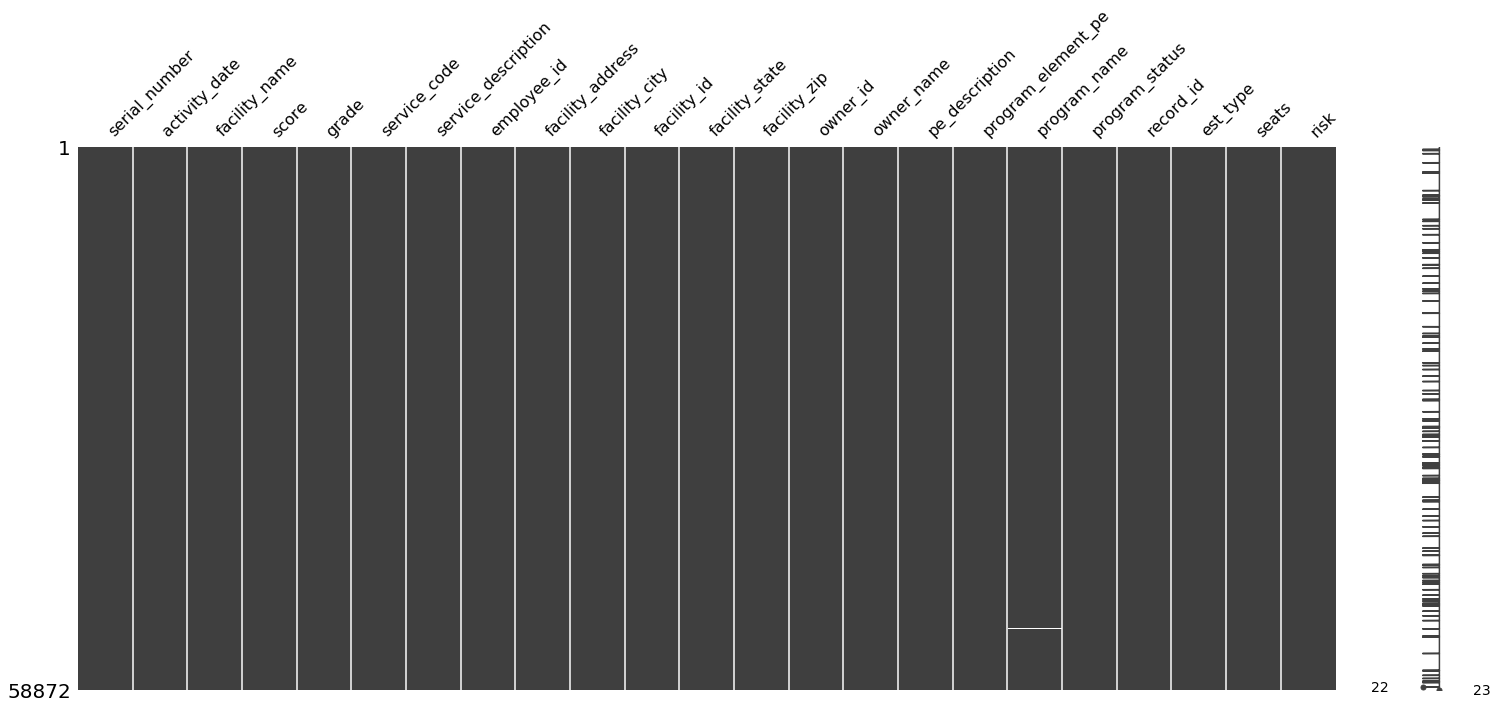

In [557]:
%matplotlib inline
msno.matrix(inspect_df)

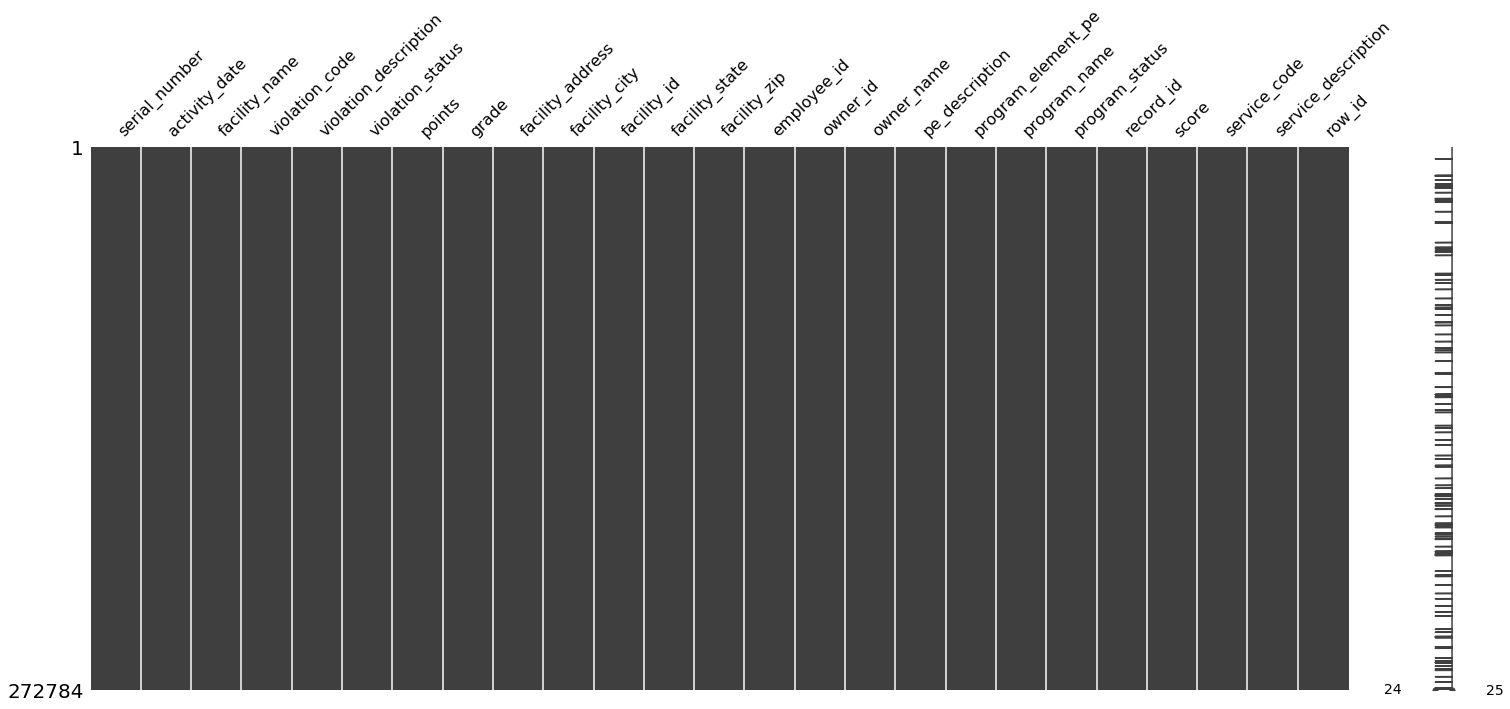

In [558]:
%matplotlib inline
msno.matrix(violate_df)

In [559]:
violate_df.head()

,serial_number,activity_date,facility_name,violation_code,violation_description,violation_status,points,grade,facility_address,facility_city,...,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,score,service_code,service_description,row_id
0,DA08R0TCU,2018-03-30,KRUANG TEDD,F030,# 30. Food properly stored; food storage conta...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF030
1,DA08R0TCU,2018-03-30,KRUANG TEDD,F027,# 27. Food separated and protected,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF027
2,DA08R0TCU,2018-03-30,KRUANG TEDD,F035,# 35. Equipment/Utensils - approved; installed...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF035
3,DA08R0TCU,2018-03-30,KRUANG TEDD,F033,# 33. Nonfood-contact surfaces clean and in go...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF033
4,DA08R0TCU,2018-03-30,KRUANG TEDD,F029,"# 29. Toxic substances properly identified, st...",OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF029


## Creating dataframe of all violation counts

Individual violations do not seem to tell us much about a particular location. Let's create a new dataframe from the violation dataframe that represents all the different violations and the total number of each violation each facility has.

We begin this by grouping the violation dataframe by the facility id and the violation code. We then aggregate by the count to find the total times each facility has violated a particular rule. 

In [560]:
vio_grouped = violate_df.groupby(['facility_id','violation_code'])
vio_counts = vio_grouped.agg({
    'violation_code': 'count'
})
vio_counts.head()

violation_code
facility_id violation_code                
FA0000968   F006                         1
            F029                         2
            F033                         3
            F035                         1
            F036                         3

We take this new dataframe and unstack it. We then transpose the resultant dataframe so that the violation codes are now the columns. We then reset the index so that a new facility_id column is created. Now we can merge the inspection dataframe with this dataframe so that each facility has a set of columns for the counts of every violation.

In [613]:
vio_matrix = vio_counts['violation_code'].unstack(0).T
vio_matrix.fillna(0, inplace=True)
vio_matrix.reset_index(inplace=True)
vio_matrix.head()

violation_code,facility_id,F001,F002,F003,F004,F005,F006,F007,F008,F009,...,F048,F049,F050,F051,F052,F053,F054,F055,F057,F058
0,FA0000968,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FA0000999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FA0001155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FA0001320,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FA0001404,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [567]:
inspect_vio_df = pd.merge(inspect_df, vio_matrix, on='facility_id', how='left')
inspect_vio_df.head()

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,...,F048,F049,F050,F051,F052,F053,F054,F055,F057,F058
0,DAJ00E07B,2017-12-29,HABITAT COFFEE SHOP,95,A,1,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DAQOKRFZB,2017-12-29,REILLY'S,92,A,1,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DASJI4LUR,2017-12-29,STREET CHURROS,93,A,1,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DAWVA0CY3,2017-12-29,RIO GENTLEMANS CLUB,93,A,1,ROUTINE INSPECTION,EE0000958,13124 S FIGUEROA ST,LOS ANGELES,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DAKFCHD0L,2017-12-29,LE PAIN QUOTIDIEN,93,A,1,ROUTINE INSPECTION,EE0000629,13050 SAN VICENTE BLVD STE 114,LOS ANGELES,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A quick look at the missing values reveals that there are a couple of facilities with NA values across all the violation codes. Lets assume that these are facilities that have never broken a rule and fillna(0) to represent zero violations.

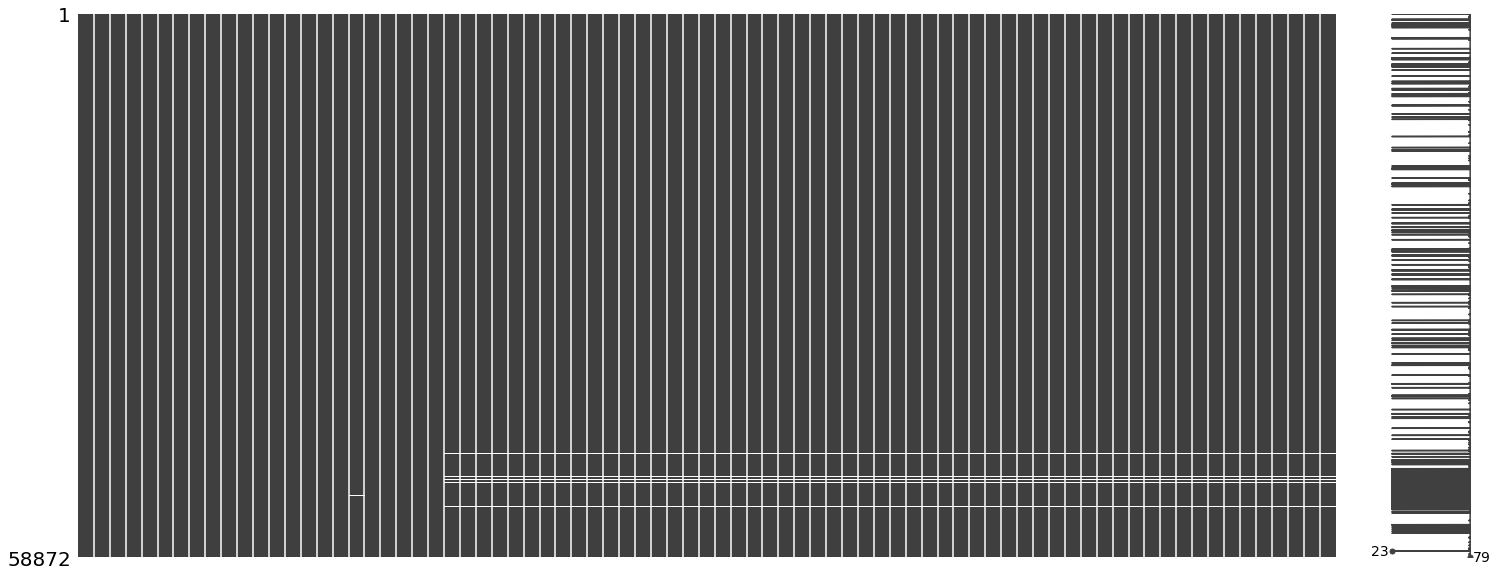

In [568]:
%matplotlib inline
msno.matrix(inspect_vio_df)

In [569]:
inspect_vio_df.fillna(0, inplace = True)

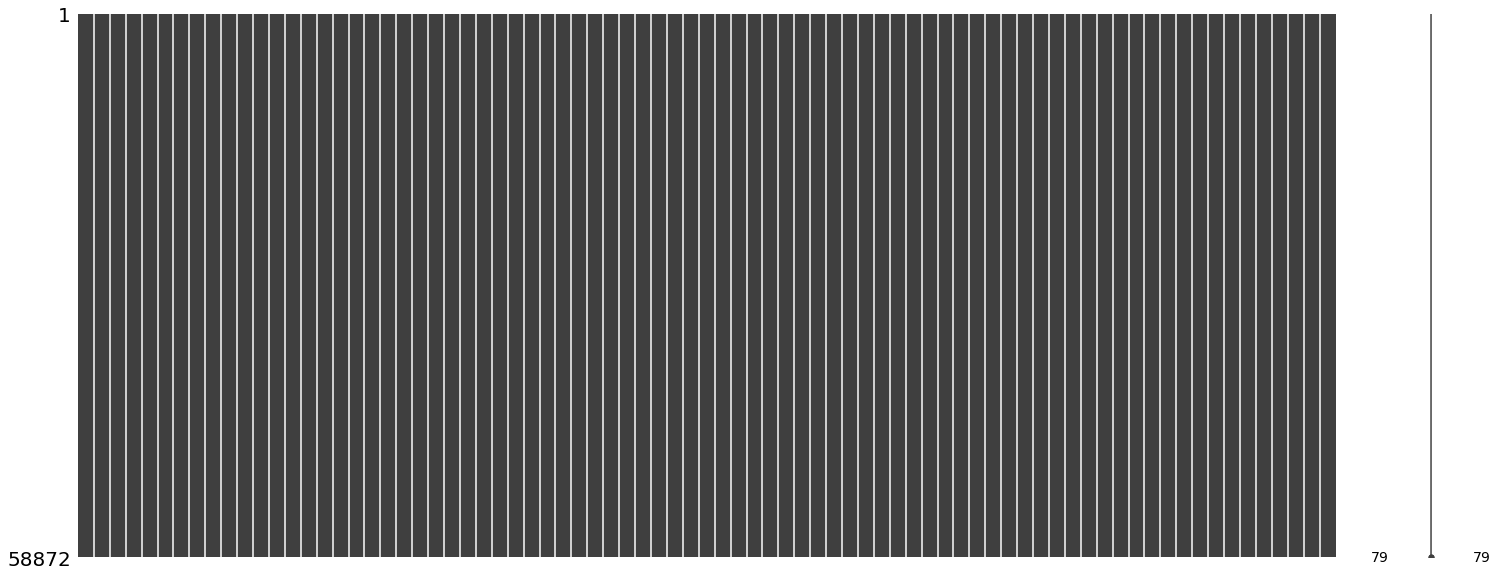

In [570]:
%matplotlib inline
msno.matrix(inspect_vio_df)

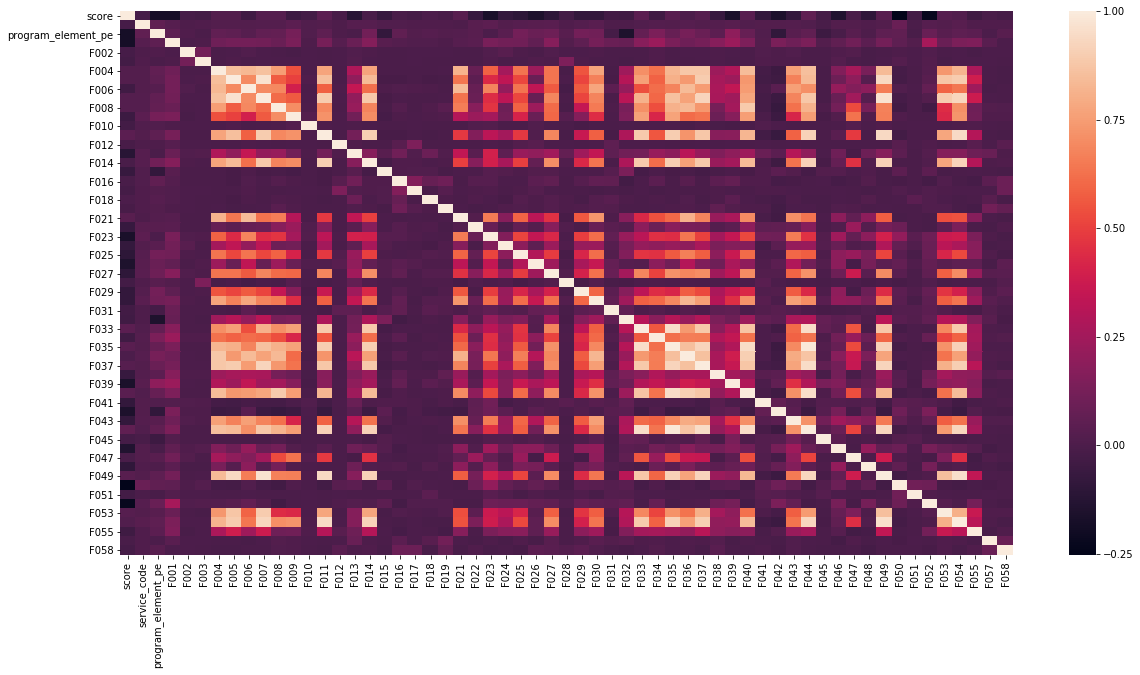

In [571]:
plt.figure(figsize=(20,10))
sb.heatmap(inspect_vio_df.corr())

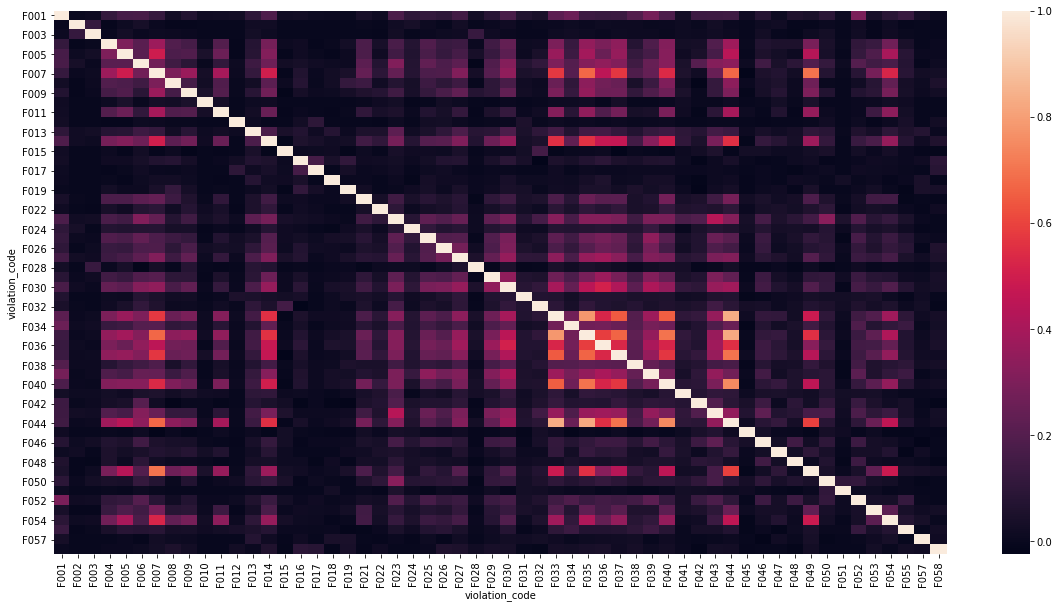

In [572]:
plt.figure(figsize=(20,10))
sb.heatmap(vio_matrix.corr())

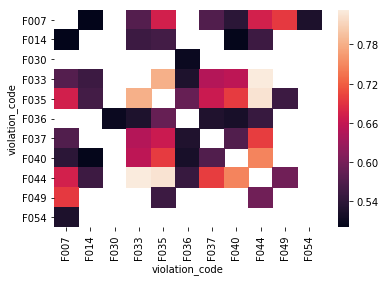

In [573]:
corr = vio_matrix.corr()
mask = (corr > 0.5) & (corr != 1.0)
masked = corr[mask]
masked.dropna(how='all', axis = 0, inplace=True)
masked.dropna(how='all', axis = 1, inplace=True)
sb.heatmap(masked)

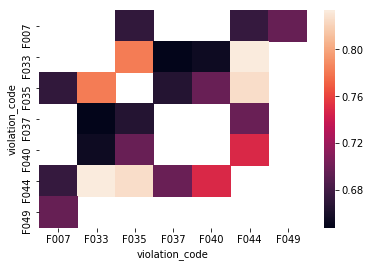

In [574]:
corr = vio_matrix.corr()
mask = (corr > 0.6) & (corr != 1.0)
masked = corr[mask]
masked.dropna(how='all', axis = 0, inplace=True)
masked.dropna(how='all', axis = 1, inplace=True)
sb.heatmap(masked)

In [575]:
inspect_vio_df.columns

Index(['serial_number', 'activity_date', 'facility_name', 'score', 'grade',
       'service_code', 'service_description', 'employee_id',
       'facility_address', 'facility_city', 'facility_id', 'facility_state',
       'facility_zip', 'owner_id', 'owner_name', 'pe_description',
       'program_element_pe', 'program_name', 'program_status', 'record_id',
       'est_type', 'seats', 'risk', 'F001', 'F002', 'F003', 'F004', 'F005',
       'F006', 'F007', 'F008', 'F009', 'F010', 'F011', 'F012', 'F013', 'F014',
       'F015', 'F016', 'F017', 'F018', 'F019', 'F021', 'F022', 'F023', 'F024',
       'F025', 'F026', 'F027', 'F028', 'F029', 'F030', 'F031', 'F032', 'F033',
       'F034', 'F035', 'F036', 'F037', 'F038', 'F039', 'F040', 'F041', 'F042',
       'F043', 'F044', 'F045', 'F046', 'F047', 'F048', 'F049', 'F050', 'F051',
       'F052', 'F053', 'F054', 'F055', 'F057', 'F058'],
      dtype='object')

In [576]:
violate_df['violation_code'].value_counts().nlargest(12).index

Index(['F044', 'F033', 'F035', 'F036', 'F040', 'F043', 'F037', 'F039', 'F030',
       'F006', 'F014', 'F007'],
      dtype='object')

## Creating a dictionary of all violations

In [577]:
violate_df[violate_df['violation_description']=='# 21a. Hot Water Available']

,serial_number,activity_date,facility_name,violation_code,violation_description,violation_status,points,grade,facility_address,facility_city,...,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,score,service_code,service_description,row_id
157,DANACKVC8,2018-03-30,SHOP RITE BROTHERS,F053,# 21a. Hot Water Available,OUT OF COMPLIANCE,2,A,1553 MANCHESTER AVE,LOS ANGELES,...,"U CAN SHOP RITE, INC.","FOOD MKT RETAIL (25-1,999 SF) LOW RISK",1610,SHOP RITE BROTHERS,ACTIVE,PR0164042,90,1,ROUTINE INSPECTION,DANACKVC8F053
241,DAXQX2YVJ,2018-03-30,SALLY'S SNACK SHOP,F053,# 21a. Hot Water Available,OUT OF COMPLIANCE,4,A,228 W 6TH ST,LOS ANGELES,...,"MARGOSSIAN, KARMEN",RESTAURANT (0-30) SEATS MODERATE RISK,1631,SALLY'S SNACK SHOP,ACTIVE,PR0037435,92,1,ROUTINE INSPECTION,DAXQX2YVJF053
305,DA3QNIBH5,2018-03-29,CUSTOM HOTEL,F053,# 21a. Hot Water Available,OUT OF COMPLIANCE,2,A,8639 LINCOLN BLVD,LOS ANGELES,...,"RAR, INC",RESTAURANT (61-150) SEATS HIGH RISK,1638,CUSTOM HOTEL-DECK 33,ACTIVE,PR0147279,93,1,ROUTINE INSPECTION,DA3QNIBH5F053
310,DA3ZAPZ7W,2018-03-29,CAFE AT THE END OF THE UNIVERSE,F053,# 21a. Hot Water Available,OUT OF COMPLIANCE,2,A,2800 E OBSERVATORY AVE,LOS ANGELES,...,WOLFGANG PUCK CATERING & EVE,RESTAURANT (61-150) SEATS MODERATE RISK,1637,CAFE AT THE END OF THE UNIVERSE,ACTIVE,PR0014441,95,1,ROUTINE INSPECTION,DA3ZAPZ7WF053
418,DACZOX7XY,2018-03-29,CHUNG KING CAFE HOUSE,F053,# 21a. Hot Water Available,OUT OF COMPLIANCE,2,C,4578 WHITTIER BLVD,LOS ANGELES,...,L & J CUISINE INC.,RESTAURANT (31-60) SEATS HIGH RISK,1635,CHUNG KING CAFE HOUSE,ACTIVE,PR0177919,71,1,ROUTINE INSPECTION,DACZOX7XYF053
613,DASLA8HTX,2018-03-29,BOTTLE FISH,F053,# 21a. Hot Water Available,OUT OF COMPLIANCE,2,A,11677 SAN VICENTE BLVD # 300,LOS ANGELES,...,"BOTTLE FISH I , LLC",RESTAURANT (61-150) SEATS HIGH RISK,1638,BOTTLE FISH,ACTIVE,PR0190251,91,1,ROUTINE INSPECTION,DASLA8HTXF053
765,DA0KWVJFB,2018-03-28,TACOS GUADALAJARA,F053,# 21a. Hot Water Available,OUT OF COMPLIANCE,2,B,1804 E VERNON AVE # D-10,LOS ANGELES,...,OSCAR CARDENAS,RESTAURANT (0-30) SEATS HIGH RISK,1632,TACOS GUADALAJARA,ACTIVE,PR0005636,86,1,ROUTINE INSPECTION,DA0KWVJFBF053
1021,DAKERIAKU,2018-03-28,LAS CHAMPAS,F053,# 21a. Hot Water Available,OUT OF COMPLIANCE,2,B,7508 S COMPTON AVE,LOS ANGELES,...,OLMOS GABRIELA PETRONA,RESTAURANT (0-30) SEATS HIGH RISK,1632,LAS CHAMPAS,ACTIVE,PR0005548,80,1,ROUTINE INSPECTION,DAKERIAKUF053
1088,DAPJD0Y1Y,2018-03-28,SMART & FINAL #330,F053,# 21a. Hot Water Available,OUT OF COMPLIANCE,2,A,10113 VENICE BLVD,LOS ANGELES,...,SMART & FINAL STORES LLC,"FOOD MKT RETAIL (2,000+ SF) LOW RISK",1613,SMART & FINAL #330,ACTIVE,PR0033114,92,1,ROUTINE INSPECTION,DAPJD0Y1YF053
1120,DAQQXIRDO,2018-03-28,MANSUR GAVRIEL,F053,# 21a. Hot Water Available,OUT OF COMPLIANCE,2,A,8475 MELROSE PL,LOS ANGELES,...,MANSUR GAVRIEL LLC,RESTAURANT (0-30) SEATS MODERATE RISK,1631,MANSUR GAVRIEL,ACTIVE,PR0207931,93,1,ROUTINE INSPECTION,DAQQXIRDOF053


code F001 and F055 -> 01a
code F052 -> 01b
code F053 -> 21a
code F021 -> 21b

In [578]:
codes = list(violate_df['violation_code'].unique())
print(codes)

['F030', 'F027', 'F035', 'F033', 'F029', 'F044', 'F006', 'F039', 'F037', 'F032', 'F034', 'F014', 'F043', 'F042', 'F009', 'F007', 'F036', 'F038', 'F048', 'F040', 'F049', 'F046', 'F023', 'F055', 'F013', 'F025', 'F053', 'F041', 'F052', 'F054', 'F024', 'F026', 'F028', 'F050', 'F008', 'F016', 'F058', 'F005', 'F045', 'F004', 'F047', 'F011', 'F022', 'F051', 'F015', 'F031', 'F057', 'F021', 'F002', 'F012', 'F003', 'F017', 'F001', 'F019', 'F018', 'F010']


In [579]:
vio_descs = list(violate_df['violation_description'].unique())
print(vio_descs)

['# 30. Food properly stored; food storage containers identified', '# 27. Food separated and protected', '# 35. Equipment/Utensils - approved; installed; clean; good repair, capacity', '# 33. Nonfood-contact surfaces clean and in good repair', '# 29. Toxic substances properly identified, stored, used', '# 44. Floors, walls and ceilings: properly built, maintained in good repair and clean', '# 06. Adequate handwashing facilities supplied & accessible', '# 39. Wiping cloths: properly used and stored', '# 37. Adequate ventilation and lighting; designated areas, use', '# 32. Food properly labeled & honestly presented', '# 34. Warewashing facilities: Adequate, maintained, properly use, test strips available', '# 14. Food contact surfaces: clean and sanitized', '# 43. Premises; personal/cleaning items; vermin-proofing', '# 42. Toilet facilities: properly constructed, supplied, cleaned', '# 09. Proper cooling methods', '# 07. Proper hot and cold holding temperatures', '# 36. Equipment, utensi

In [580]:
violation_dict = dict.fromkeys(codes)

In [581]:
for x in violation_dict:
    for desc in vio_descs:
        if x[-2:] == desc[2:4]:
            violation_dict[x] = desc
violation_dict

{'F001': '# 01b. Food safety certification',
 'F002': '# 02. Communicable disease; reporting, restrictions & exclusions',
 'F003': '# 03. No discharge from eyes, nose, and mouth',
 'F004': '# 04. Proper eating, drinking, or tobacco use',
 'F005': '# 05. Hands clean and properly washed; gloves used properly',
 'F006': '# 06. Adequate handwashing facilities supplied & accessible',
 'F007': '# 07. Proper hot and cold holding temperatures',
 'F008': '# 08. Time as a public health control; procedures & records',
 'F009': '# 09. Proper cooling methods',
 'F010': '# 10. Proper cooking time & temperatures',
 'F011': '# 11. Proper reheating procedures for hot holding',
 'F012': '# 12. Returned and reservice food',
 'F013': '# 13. Food in good condition, safe and unadulterated',
 'F014': '# 14. Food contact surfaces: clean and sanitized',
 'F015': '# 15. Food obtained from approved source',
 'F016': '# 16. Compliance with shelf stock tags, condition, displayed',
 'F017': '# 17. Compliance with G

In [582]:
violation_dict['F001'] = '# 01a. Demonstration of knowledge'
violation_dict['F052'] = '# 01b. Food safety certification'
violation_dict['F053'] = '# 21a. Hot Water Available'
violation_dict['F054'] = '# 52. Multiple Major Critical Violations / Increased Risk to Public Health'
violation_dict['F055'] = '# 01a. Demonstration of knowledge'
violation_dict['F057'] = '# 18. Compliance with variance, specialized process, & HACCP Plan'
violation_dict['F058'] = '# 19. Consumer advisory provided for raw or undercooked foods'

In [583]:
violation_dict

{'F001': '# 01a. Demonstration of knowledge',
 'F002': '# 02. Communicable disease; reporting, restrictions & exclusions',
 'F003': '# 03. No discharge from eyes, nose, and mouth',
 'F004': '# 04. Proper eating, drinking, or tobacco use',
 'F005': '# 05. Hands clean and properly washed; gloves used properly',
 'F006': '# 06. Adequate handwashing facilities supplied & accessible',
 'F007': '# 07. Proper hot and cold holding temperatures',
 'F008': '# 08. Time as a public health control; procedures & records',
 'F009': '# 09. Proper cooling methods',
 'F010': '# 10. Proper cooking time & temperatures',
 'F011': '# 11. Proper reheating procedures for hot holding',
 'F012': '# 12. Returned and reservice food',
 'F013': '# 13. Food in good condition, safe and unadulterated',
 'F014': '# 14. Food contact surfaces: clean and sanitized',
 'F015': '# 15. Food obtained from approved source',
 'F016': '# 16. Compliance with shelf stock tags, condition, displayed',
 'F017': '# 17. Compliance with 

## Geographical groupings

In [616]:
inspect_df['facility_zip'].head(15)

0          90065
1          90045
2          90028
3          90064
4          90049
5     90026-3227
6          90011
7          90026
8          90034
9     90043-4706
10         90045
11         90047
12         90020
13         90065
14         91604
Name: facility_zip, dtype: object

In [585]:
inspect_vio_df.loc[1]

serial_number                                      DAQOKRFZB
activity_date                            2017-12-29 00:00:00
facility_name                                       REILLY'S
score                                                     92
grade                                                      A
service_code                                               1
service_description                       ROUTINE INSPECTION
employee_id                                        EE0000633
facility_address                         100 WORLD WAY # 120
facility_city                                    LOS ANGELES
facility_id                                        FA0244690
facility_state                                            CA
facility_zip                                           90045
owner_id                                           OW0208441
owner_name                         AREAS SKYVIEW LAX JV, LLC
pe_description         RESTAURANT (0-30) SEATS MODERATE RISK
program_element_pe      

In [586]:
def clean_zip(x):
    return x[:5]
inspect_vio_df['facility_zip'] = inspect_vio_df['facility_zip'].apply(clean_zip)

In [587]:
geo_group = inspect_vio_df.groupby('facility_zip')
geo_agg = geo_group.agg({'score': np.mean,
                       'facility_id': pd.Series.nunique,
                        })
geo_agg.rename(columns = {'score':'average_score','facility_id':'total_facilities'}, inplace = True)
geo_agg.reset_index(inplace=True)

,facility_zip,average_score,total_facilities
0,90001,93.987292,276
1,90002,94.570175,69
2,90003,92.843198,276
3,90004,92.673001,277
4,90005,91.307221,302
5,90006,92.586446,431
6,90007,94.790235,252
7,90008,94.182670,96
8,90010,92.301523,202
9,90011,93.330645,340


In [588]:
# load GeoJSON
with open('la-zip-code-areas-2012.geojson', 'r') as jsonFile:
    data = json.load(jsonFile)
tmp = data

# remove ZIP codes not in our dataset
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['name'] in list(geo_agg['facility_zip'].unique()):
        geozips.append(tmp['features'][i])

# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# save JSON object as updated-file
open("updated-file.json", "w").write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

1160874

In [589]:
x = 'average_score'
print((' ').join(x.split('_')).title())

Average Score


In [590]:
import folium

# table = main table/data frame we read from (pandas DataFrame)
# zips = column name where ZIP codes are (string)
# mapped_feature = column name for feature we want to visualize (string)
# add_text = any additional commentary to be added in the map legend (string)

def create_map(table, zips, mapped_feature, add_text = ''):
    # reading of the updated GeoJSON file
    la_geo = r'updated-file.json'
    # initiating a Folium map with LA's longitude and latitude
    m = folium.Map(location = [34.0522, -118.2437], zoom_start = 11)
    # creating a choropleth map
    m.choropleth(
        geo_data = la_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'feature.properties.name',
        # first element contains location information, second element contains feature of interest
        columns = [zips, mapped_feature],
        fill_color = 'RdYlGn',
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' ' + add_text + ' Across LA'
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = mapped_feature + '_map.html')

In [591]:
create_map(geo_agg, 'facility_zip', 'average_score', 'of Facilities')

In [592]:
create_map(geo_agg, 'facility_zip', 'total_facilities')

In [593]:
# code before helper function was created

# la_geo = r'updated-file.json'
# m = folium.Map(location = [34.0522, -118.2437], zoom_start = 11)
# m.choropleth(
#     geo_data = la_geo,
#     fill_opacity = 0.7,
#     line_opacity=0.2,
#     data = geo_agg,
#     key_on = 'feature.properties.name',
#     columns = ['facility_zip','average_score'],
#     fill_color='RdYlGn',
#     legend_name='Average Inspection Score',
# )
# folium.LayerControl().add_to(m)
# m.save(outfile='average_score_map.html')

In [594]:
# code before helper function was created

# m2 = folium.Map(location = [34.0522, -118.2437], zoom_start = 11)
# m2.choropleth(
#     geo_data = la_geo,
#     fill_opacity = 0.7,
#     line_opacity=0.2,
#     data = geo_agg,
#     key_on = 'feature.properties.name',
#     columns = ['facility_zip','total_facilities'],
#     fill_color='RdYlGn',
#     legend_name='Total Establishments in Each Zip Code',
# )
# folium.LayerControl().add_to(m2)
# m2.save(outfile='total_establishments_map.html')

In [595]:
fac_grouped = inspect_vio_df.groupby(['facility_zip','facility_id'])
fac_agg = fac_grouped.agg({'F044': np.mean,
                        'F033': np.mean,
                        'F035': np.mean,
                        'F036': np.mean,
                        'F040': np.mean,
                        'F043': np.mean,
                        'F037': np.mean,
                        'F039': np.mean,
                        'F030': np.mean,
                        'F006': np.mean,
                        'F014': np.mean,
                        'F007': np.mean})

In [596]:
fac_agg.head(10)

F044  F033  F035  F036  F040  F043  F037  F039  \
facility_zip facility_id                                                   
90001        FA0002183     6.0   3.0   4.0   1.0   1.0   3.0   5.0   0.0   
             FA0002627     1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
             FA0004443     1.0   1.0   1.0   0.0   0.0   1.0   0.0   0.0   
             FA0004465     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
             FA0004529     3.0   1.0   0.0   0.0   0.0   2.0   0.0   0.0   
             FA0004739     6.0   3.0   2.0   0.0   1.0   3.0   2.0   1.0   
             FA0004873     1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
             FA0005313     4.0   0.0   2.0   2.0   1.0   4.0   0.0   0.0   
             FA0005764     7.0   3.0   4.0   0.0   2.0   5.0   1.0   3.0   
             FA0005770     3.0   1.0   3.0   3.0   3.0   2.0   0.0   0.0   

                          F030  F006  F014  F007  
facility_zip facility_id                          
90001        FA0002183     2.0   1.0   0.0   2.0  
             FA0002627     0.0   0.0   0.0   0.0  
             FA0004443     0.0   0.0   0.0   0.0  
             FA0004465     0.0   0.0   0.0   0.0  
             FA0004529     0.0   0.0   0.0   0.0  
             FA0004739     2.0   2.0   1.0   0.0  
             FA0004873     0.0   0.0   0.0   0.0  
             FA0005313     0.0   2.0   0.0   0.0  
             FA0005764     4.0   2.0   1.0   1.0  
             FA0005770     1.0   1.0   1.0   0.0

In [597]:
fac_agg = fac_agg.groupby(level=0).mean()
fac_agg.reset_index(inplace=True)

In [598]:
fac_agg.head()

,facility_zip,F044,F033,F035,F036,F040,F043,F037,F039,F030,F006,F014,F007
0,90001,1.717391,1.257246,1.184783,0.655797,0.637681,1.054348,0.782609,0.398551,0.492754,1.090580,0.387681,0.554348
1,90002,1.724638,1.318841,0.753623,0.434783,0.492754,0.971014,0.536232,0.318841,0.434783,0.942029,0.188406,0.376812
2,90003,1.728261,1.695652,1.282609,0.666667,0.670290,1.387681,0.630435,0.369565,0.663043,1.112319,0.380435,0.684783
3,90004,2.729242,2.649819,1.888087,1.595668,1.169675,1.472924,0.794224,0.631769,1.000000,0.953069,0.985560,0.541516
4,90005,2.940397,2.986755,2.125828,1.635762,1.745033,2.099338,1.463576,2.105960,1.480132,1.122517,1.354305,0.880795


In [599]:
def count_distribution(df,location,subgroup):
    group_counts = pd.DataFrame(df.groupby([location,subgroup]).size().unstack(1))
    group_counts.reset_index(inplace = True)
    return group_counts

def subgroup_distribution(df,location,subgroup):
    group = df.groupby([location,subgroup]).size()
    group_pcts = group.groupby(level=0).apply(lambda x: 100 * x/float(x.sum()))
    group_pcts = pd.DataFrame(group_pcts.unstack(1))
    group_pcts.reset_index(inplace=True)
    return group_pcts

In [600]:
seats_counts = count_distribution(inspect_vio_df, 'facility_zip', 'seats')
est_type_counts = count_distribution(inspect_vio_df, 'facility_zip', 'est_type')
risk_counts = count_distribution(inspect_vio_df, 'facility_zip', 'risk')

In [601]:
# before helper function was written

# seat_counts = pd.DataFrame(inspect_vio_df.groupby(['facility_zip', 'seats']).size().unstack(1))
# seat_counts.reset_index(inplace=True)
# seat_counts.head()

In [602]:
# risk_group = inspect_vio_df.groupby(['facility_zip','risk']).size()

In [603]:
# risk_pcts = risk_group.groupby(level=0).apply(lambda x: 100 * x/float(x.sum()))

In [604]:
# risk_pcts = pd.DataFrame(risk_pcts.unstack(1))
# risk_pcts.reset_index(inplace=True)
# risk_pcts

In [605]:
seats_dist = subgroup_distribution(inspect_vio_df, 'facility_zip', 'seats')
est_type_dist = subgroup_distribution(inspect_vio_df, 'facility_zip', 'est_type')
risk_dist = subgroup_distribution(inspect_vio_df, 'facility_zip', 'risk')

In [606]:
seats_dist.head()

seats,facility_zip,0-30,151 +,"2,000+ SF","25-1,999 SF",31-60,61-150
0,90001,45.259042,2.346041,8.308895,30.009775,12.805474,1.270772
1,90002,32.894737,2.631579,14.473684,41.228070,3.947368,4.824561
2,90003,46.936656,NaN,5.815161,38.733126,5.399792,3.115265
3,90004,36.737926,1.979414,6.571655,11.955661,24.386382,18.368963
4,90005,27.384196,5.858311,4.019074,12.602180,31.471390,18.664850


In [607]:
create_map(seats_counts, 'facility_zip', '0-30', 'Occupancy Facility Total Count')
create_map(seats_counts, 'facility_zip', '2,000+ SF', 'Occupancy Facility Total Count')

In [620]:
create_map(seats_dist, 'facility_zip', '0-30', 'Occupancy Concentration')
create_map(seats_dist, 'facility_zip', '2,000+ SF', 'Occupancy Concentration')

In [626]:
create_map(seats_counts, 'facility_zip', '0-30', 'Occupancy Count')
create_map(seats_counts, 'facility_zip', '31-60', 'Occupancy Count')
create_map(seats_counts, 'facility_zip', '61-150', 'Occupancy Count')

In [608]:
est_type_dist.head()

est_type,facility_zip,FOOD MKT RETAIL,RESTAURANT
0,90001,38.318671,61.681329
1,90002,55.701754,44.298246
2,90003,44.548287,55.451713
3,90004,18.527316,81.472684
4,90005,16.621253,83.378747


In [609]:
create_map(est_type_counts, 'facility_zip', 'FOOD MKT RETAIL', ' Total Count')
create_map(est_type_counts, 'facility_zip', 'RESTAURANT', ' Total Count')

In [610]:
risk_dist.head()

risk,facility_zip,HIGH RISK,LOW RISK,MODERATE RISK
0,90001,60.410557,19.550342,20.039101
1,90002,41.228070,28.947368,29.824561
2,90003,49.428868,24.195223,26.375909
3,90004,69.358670,12.430721,18.210610
4,90005,72.207084,11.989101,15.803815


In [618]:
create_map(risk_counts, 'facility_zip', 'LOW RISK', ' Facilities Total Count')
create_map(risk_counts, 'facility_zip', 'HIGH RISK', ' Facilities Total Count')

In [617]:
est_type_counts.head()

est_type,facility_zip,FOOD MKT RETAIL,RESTAURANT
0,90001,392.0,631.0
1,90002,127.0,101.0
2,90003,429.0,534.0
3,90004,234.0,1029.0
4,90005,244.0,1224.0


In [627]:
create_map(fac_agg, 'facility_zip', 'F044', 'Average Violation of Facility Structure')